# AI-Vive Banking Exploratory Data Analysis

By Tan Song Xin Alastiar

In [1]:
import sqlite3
file_loc = 'data/bmarket.db'

conn = sqlite3.connect(file_loc)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

if tables:
  table_name = tables[0][0]  # Assuming there's at least one table
  print(f"Table Name: {table_name}")

  cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
  rows = cursor.fetchall()

  if rows:
    # Get column names
    cursor.execute(f"PRAGMA table_info({table_name})")
    column_names = [i[1] for i in cursor.fetchall()]

    print("Column Headers:", column_names)
    for row in rows:
      print(row)

  else:
    print("No data found in the table.")
else:
  print("No tables found in the database.")

Table Name: bank_marketing
Column Headers: ['Client ID', 'Age', 'Occupation', 'Marital Status', 'Education Level', 'Credit Default', 'Housing Loan', 'Personal Loan', 'Contact Method', 'Campaign Calls', 'Previous Contact Days', 'Subscription Status']
(32885, '57 years', 'technician', 'married', 'high.school', 'no', 'no', 'yes', 'Cell', 1, 999, 'no')
(3170, '55 years', 'unknown', 'married', 'unknown', 'unknown', 'yes', 'no', 'telephone', 2, 999, 'no')
(32207, '33 years', 'blue-collar', 'married', 'basic.9y', 'no', 'no', 'no', 'cellular', 1, 999, 'no')
(9404, '36 years', 'admin.', 'married', 'high.school', 'no', 'no', 'no', 'Telephone', 4, 999, 'no')
(14021, '27 years', 'housemaid', 'married', 'high.school', 'no', None, 'no', 'Cell', 2, 999, 'no')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Read data into pandas
bank_df = pd.read_sql_query("SELECT * FROM bank_marketing", conn)
conn.close() # Close connection as no longer needed.

print(bank_df.head()) # Check if table is set as dataframe

   Client ID       Age   Occupation Marital Status Education Level  \
0      32885  57 years   technician        married     high.school   
1       3170  55 years      unknown        married         unknown   
2      32207  33 years  blue-collar        married        basic.9y   
3       9404  36 years       admin.        married     high.school   
4      14021  27 years    housemaid        married     high.school   

  Credit Default Housing Loan Personal Loan Contact Method  Campaign Calls  \
0             no           no           yes           Cell               1   
1        unknown          yes            no      telephone               2   
2             no           no            no       cellular               1   
3             no           no            no      Telephone               4   
4             no         None            no           Cell               2   

   Previous Contact Days Subscription Status  
0                    999                  no  
1               

In [3]:
print(bank_df.count())
print(bank_df.dtypes)

# Checks for oddities in the string values
print("Age:", bank_df['Age'].unique())
print("Occupation:", bank_df['Occupation'].unique())
print("Marital Status:", bank_df['Marital Status'].unique())
print("Education Level:", bank_df['Education Level'].unique())
print("Credit Default:", bank_df['Credit Default'].unique())
print("Housing Loan:", bank_df['Housing Loan'].unique())
print("Personal Loan:", bank_df['Personal Loan'].unique())
print("Contact Method:", bank_df['Contact Method'].unique())
print("Campaign Calls:", bank_df['Campaign Calls'].unique())
print("Previous Contact Days:", bank_df['Previous Contact Days'].unique())
print("Subscription Status:", bank_df['Subscription Status'].unique())

Client ID                41188
Age                      41188
Occupation               41188
Marital Status           41188
Education Level          41188
Credit Default           41188
Housing Loan             16399
Personal Loan            37042
Contact Method           41188
Campaign Calls           41188
Previous Contact Days    41188
Subscription Status      41188
dtype: int64
Client ID                 int64
Age                      object
Occupation               object
Marital Status           object
Education Level          object
Credit Default           object
Housing Loan             object
Personal Loan            object
Contact Method           object
Campaign Calls            int64
Previous Contact Days     int64
Subscription Status      object
dtype: object
Age: ['57 years' '55 years' '33 years' '36 years' '27 years' '58 years'
 '48 years' '150 years' '24 years' '34 years' '42 years' '43 years'
 '26 years' '37 years' '46 years' '59 years' '49 years' '30 years'
 '51 years

In [4]:
print("Occupation = 'unknown' count:", (bank_df['Occupation'] == 'unknown').sum())
print("Age = '150 years' count:", (bank_df['Age'] == '150 years').sum())
print("Marital Status = 'unknown' count:", (bank_df['Marital Status'] == 'unknown').sum())
print("Education Level = 'unknown' count:", (bank_df['Education Level'] == 'unknown').sum())
print("Credit Default = 'unknown' count:", (bank_df['Credit Default'] == 'unknown').sum())
print("Campaign Calls <= -1 count:", (bank_df['Campaign Calls'] <= -1).sum())
print("Previous Contact Days = 0 or = 999 count:", bank_df['Previous Contact Days'].isin([0, 999]).sum() )
print("Previous Contact Days = 0 count:", bank_df['Previous Contact Days'].isin([0]).sum() )
print("Previous Contact Days = 999 count:", bank_df['Previous Contact Days'].isin([999]).sum() )

Occupation = 'unknown' count: 330
Age = '150 years' count: 4197
Marital Status = 'unknown' count: 80
Education Level = 'unknown' count: 1731
Credit Default = 'unknown' count: 8597
Campaign Calls <= -1 count: 4153
Previous Contact Days = 0 or = 999 count: 39688
Previous Contact Days = 0 count: 15
Previous Contact Days = 999 count: 39673


## Preliminary Datatype Analysis:

**Client ID:** Int64. Valid data type, but should be dropped as not useful for training.  

**Age:** Object, presumably string. Will need to clean column to change to integer. One value of 150 years is nonsensical (the oldest recorded ever living human as of 2025 is Jeanne Calment, who lived for 122 years). However, it compromises of nearly 10% of all records.  
*This implies a glitch in the system causing this*. This will either need to be masked, or imputed.

**Occupation:** Object, presumably string. Unknown fields may be imputed, treated as their own category, or data masked.  

**Marital Status:** Object, presumably string. One-hot encoding to be done. Unknown records to be left as is or masked in deep models.  

**Education Level:** Object, presumably string. One-hot-encoding to be done. Unknown records to be left as is or masked in deep models.  

**Credit Default:** Object, presumably string. One-hot-encoding to be done. Greater than 25% of records are Unknown/None fields, they will be treated as their own category or have their data masked.  

**Housing Loan:** Object, presumably string. One-hot-encoding to be done. Greater than 25% of records are Unknown/None fields, they will be treated as their own category or have their data masked.    

**Personal Loan:** Object, presumably string. One-hot-encoding to be done. Greater than 25% of records are Unknown/None fields, they will be treated as their own category or have their data masked.  

**Contact Method:** Object, presumably string. One-hot-encoding to be done, and standardisation for 'cell' and 'telephone' and its variants will need to be done.  

**Campaign Calls:** Integer. Some negative values, which make zero sense. Will consider either flipping all negative values to positive values, or data masking.  

**Previous Contact Days:** Integer. Both 0 and 999 exist as values. Data description says that 999 means no previous contact. Assumption is that 0 means that last contact day was the day this data was collected.

**Subscription Status:** 'Yes' and 'No'. Labels. Will convert to 0 and 1, or potentially values between [0.0, 0.1] and [0.9, 1.0] for the purpose of soft-labelling.

## Exploratory Data Analysis

We will perform some exploratory data analysis, cleaning some of the data for better presentation, with the assumptions of data cleaning included with each graph.

Age Data Before Imputation

count    41188.000000
mean        51.231572
std         34.708486
min         17.000000
25%         33.000000
50%         40.000000
75%         51.000000
max        150.000000
Name: Age_Integer, dtype: float64


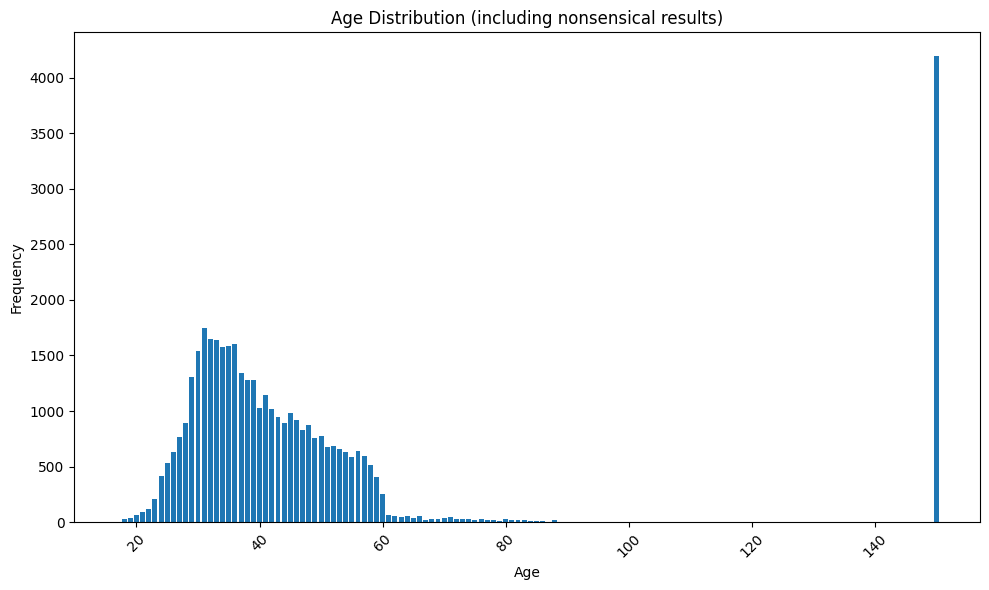

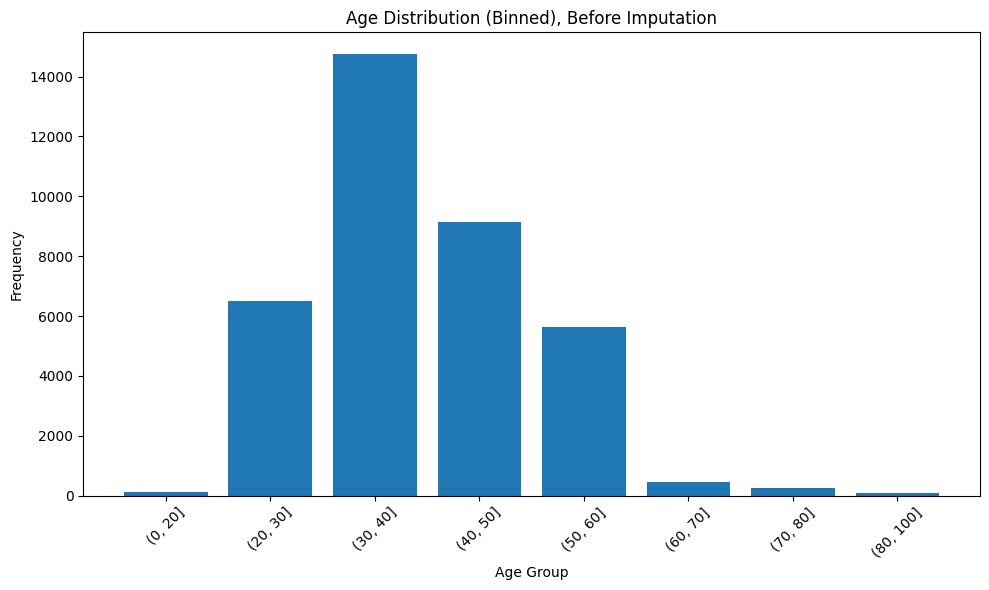

Age Data After Imputation

count    41188.000000
mean        40.010877
std         10.189921
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: Age_Integer, dtype: float64


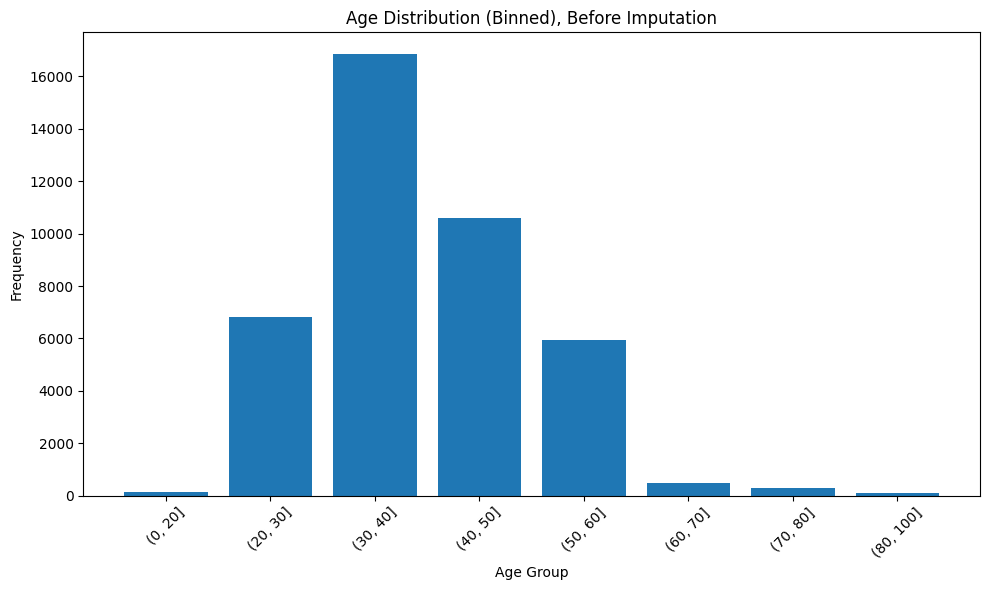

In [5]:
bank_df_age = bank_df.copy()
bank_df_age["Age_Integer"] = bank_df_age["Age"].str.extract(r'(\d+)').astype(int)

print("Age Data Before Imputation")
print("")
print(bank_df_age["Age_Integer"].describe())

# Count frequency of each age
age_counts = bank_df_age["Age_Integer"].value_counts().sort_index()

# Plot as bar chart
plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (including nonsensical results)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

bank_df_age['Age Bin'] = pd.cut(bank_df_age['Age_Integer'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 100])
age_bin_counts = bank_df_age['Age Bin'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(age_bin_counts.index.astype(str), age_bin_counts.values)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Distribution (Binned), Before Imputation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Age Data After Imputation")
print("")

# Imputing using KNN Imputer
from sklearn.impute import KNNImputer

bank_df_age_2 = bank_df_age.copy()

bank_df_age_2.loc[bank_df_age_2["Age_Integer"] > 100, 'Age_Integer'] = np.nan
bank_df_age_2.drop('Age', axis=1, inplace=True)
bank_df_age_2.drop('Age Bin', axis=1, inplace=True)
bank_df_age_2.drop('Client ID', axis=1, inplace=True)

# Other fields are also cleaned up first, no imputation done
bank_df_age_2.loc[bank_df_age_2["Housing Loan"].isna(), "Housing Loan"] = 'unknown'
bank_df_age_2.loc[bank_df_age_2["Personal Loan"].isna(), "Personal Loan"] = 'unknown'
bank_df_age_2.loc[bank_df_age_2["Contact Method"] == 'Cell', "Contact Method"] = 'cellular'
bank_df_age_2.loc[bank_df_age_2["Contact Method"] == 'Telephone', "Contact Method"] = 'telephone'
bank_df_age_2["Campaign Calls"] = bank_df_age_2["Campaign Calls"].abs()

bank_df_age_2.drop("Subscription Status", axis=1, inplace=True)

# One hot encoding is done
bank_df_age_2 = pd.get_dummies(bank_df_age_2, columns=["Occupation", "Marital Status", "Education Level", "Credit Default", "Housing Loan", "Personal Loan", "Contact Method"])

imputer = KNNImputer(n_neighbors=3)
imputed_array = imputer.fit_transform(bank_df_age_2)
df_imputed = pd.DataFrame(imputed_array, columns=bank_df_age_2.columns, index=bank_df_age_2.index)
#bank_df_age_2[bank_df_age_2.columns] = df_imputed

print(df_imputed["Age_Integer"].describe())

df_imputed['Age Bin'] = pd.cut(df_imputed['Age_Integer'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 100])
age_bin_counts = df_imputed['Age Bin'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(age_bin_counts.index.astype(str), age_bin_counts.values)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Distribution (Binned), Before Imputation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Age Distribution follows roughly a Gaussian distribution, with some fat tails, especially from the error data of 150 years. After imputation, there is no visible change in the data arrangement.

## Occupation Distribution

There are many categories, and likely overfitting will occur if these categories are kept. In the end, some feature engineering is done, coalescing the job categories into the following:

* blue-collar: consisting of those categorised as 'technician', 'housemaid', 'blue-collar'
* white-collar: consisting of those categorised as 'admin.', 'management', 'services'
* self-employed: consisting of those categorised as 'entrepreneur' and 'self-employed'
* Students, the retired, unemployed, and those marked as unknown remain the same

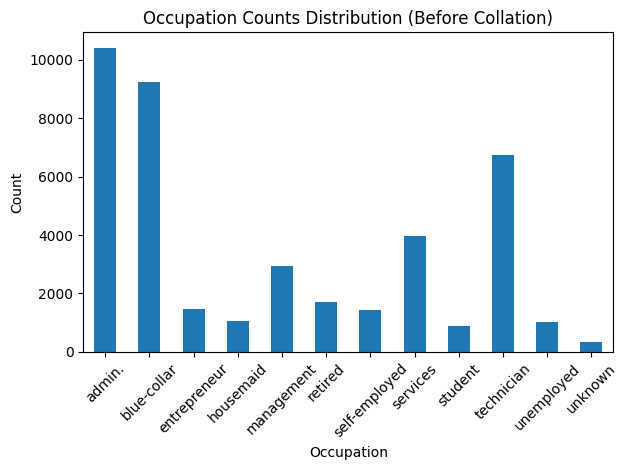

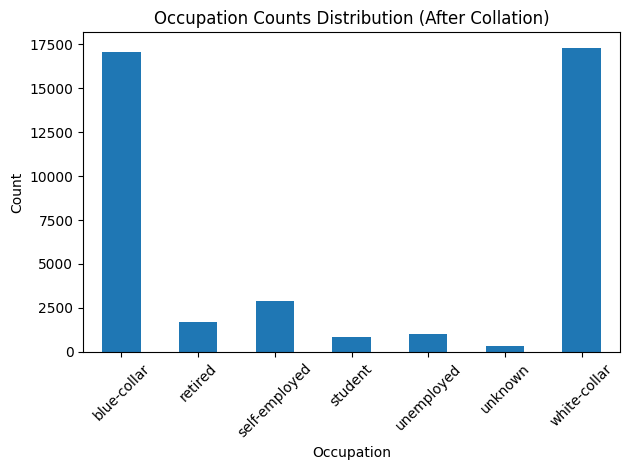

In [6]:
bank_df_2 = bank_df.copy()

bank_df_2['Occupation'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Occupation Counts Distribution (Before Collation)')
plt.tight_layout()
plt.show()

bank_df_3 = bank_df.copy()

# Collation
bank_df_3.loc[bank_df_3['Occupation'].isin(['blue-collar', 'housemaid', 'technician']), 'Occupation'] = 'blue-collar' 
bank_df_3.loc[bank_df_3['Occupation'].isin(['admin.', 'management', 'services']), 'Occupation'] = 'white-collar'
bank_df_3.loc[bank_df_3['Occupation'].isin(['entrepreneur', 'self-employed']), 'Occupation'] = 'self-employed'

bank_df_3['Occupation'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Occupation Counts Distribution (After Collation)')
plt.tight_layout()
plt.show()

## Education Distribution

There are many categories, and likely overfitting will occur if these categories are kept. In the end, some feature engineering is done, coalescing the education categories into the following:

* high.school.ab: "High school and below". Consists of everyone with high school education, basic education, or illiterate
* The rest of the categories are kept.

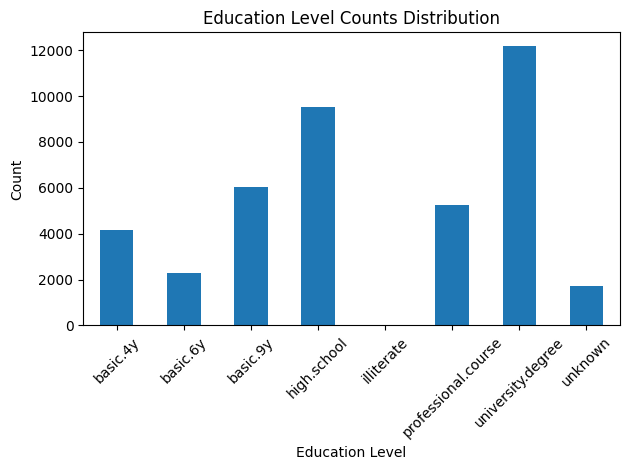

Number of Illiterate Records: 18
Number of Unknown Records: 1731


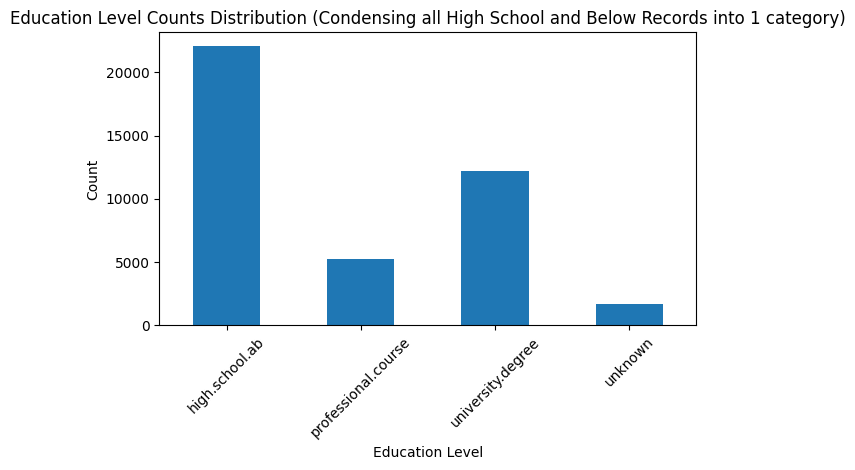

In [7]:
bank_df_2 = bank_df.copy()

bank_df_2['Education Level'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Education Level Counts Distribution')
plt.tight_layout()
plt.show()

print("Number of Illiterate Records:", bank_df_2.loc[bank_df_2['Education Level'] == 'illiterate', 'Education Level'].count())
print("Number of Unknown Records:", bank_df_2.loc[bank_df_2['Education Level'] == 'unknown', 'Education Level'].count())

bank_df_2 = bank_df.copy()

# Collation
bank_df_2.loc[bank_df_2['Education Level'].isin(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate']), 'Education Level'] = 'high.school.ab'

bank_df_2['Education Level'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Education Level Counts Distribution (Condensing all High School and Below Records into 1 category)')
plt.tight_layout()
plt.show()

## Marital Status

No imputation is done.

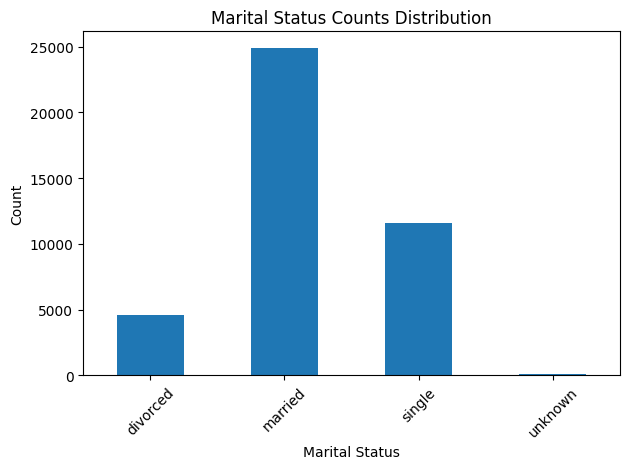

In [8]:
bank_df_2 = bank_df.copy()

bank_df_2['Marital Status'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Marital Status Counts Distribution')
plt.tight_layout()
plt.show()

## Credit Default Distribution

There are so few "Yes" results that it was decided that dropping these records would reduce overfitting.

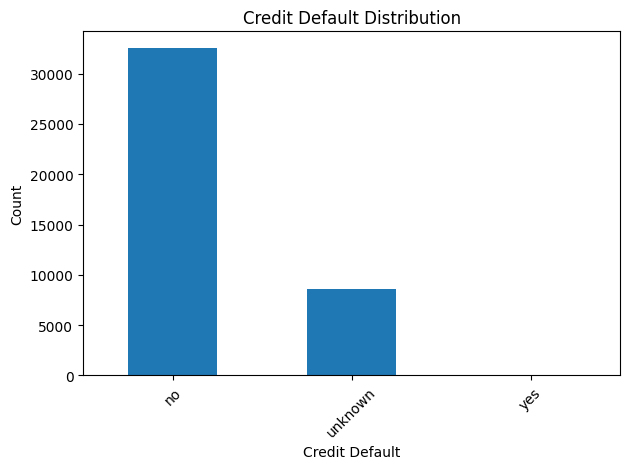

In [9]:
bank_df_4 = bank_df.copy()

bank_df_4['Credit Default'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Credit Default')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Credit Default Distribution')
plt.tight_layout()
plt.show()

## Housing Loan Distribution

There are a large number of 'None' records. They will be reclassified as 'Unknown'.

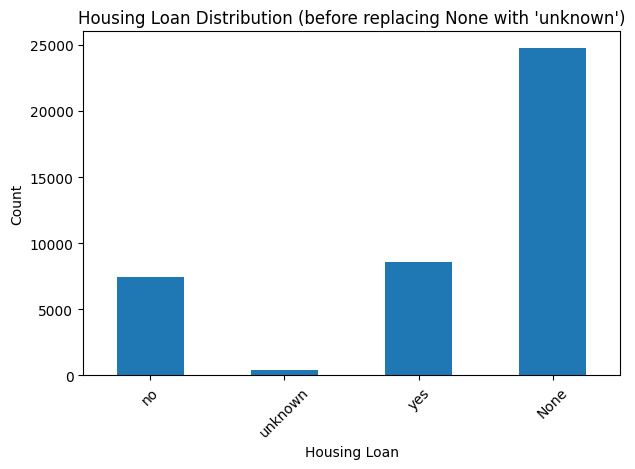

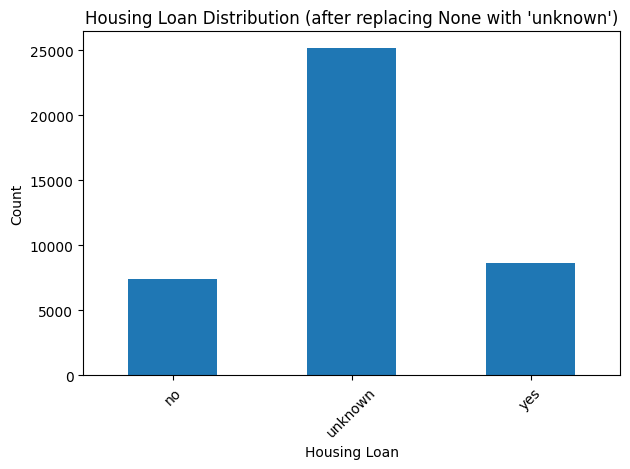

In [10]:
bank_df_5 = bank_df.copy()

bank_df_5['Housing Loan'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title("Housing Loan Distribution (before replacing None with 'unknown')")
plt.tight_layout()
plt.show()

# Imputation through replacement
bank_df_5 = bank_df.copy()

bank_df_5.loc[bank_df_5["Housing Loan"].isna(), "Housing Loan"] = 'unknown'

bank_df_5['Housing Loan'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title("Housing Loan Distribution (after replacing None with 'unknown')")
plt.tight_layout()
plt.show()

## Personal Loan Distribution

There are a significant number of 'None' records. They will be reclassified as 'Unknown'.

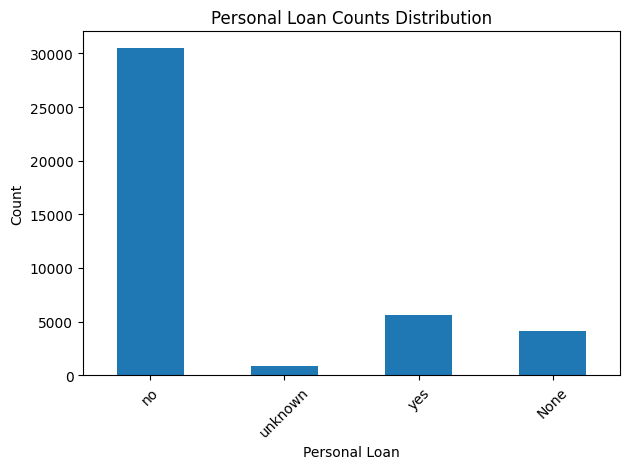

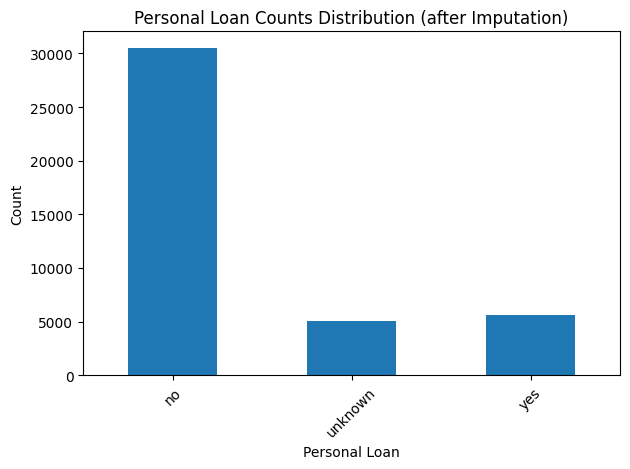

In [11]:
bank_df_2 = bank_df.copy()

bank_df_2['Personal Loan'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Personal Loan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Personal Loan Counts Distribution')
plt.tight_layout()
plt.show()

# Impute None as 'unknown'

bank_df_2 = bank_df.copy()
bank_df_2.loc[bank_df_2["Personal Loan"].isna(), "Personal Loan"] = 'unknown'

bank_df_2['Personal Loan'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Personal Loan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Personal Loan Counts Distribution (after Imputation)')
plt.tight_layout()
plt.show()

## Contact Method Distribution

There is only a slight difference in cellular vs telephone records. Initially, there were misspelled records and records with different cases, but those are easily cleaned into the right categories.

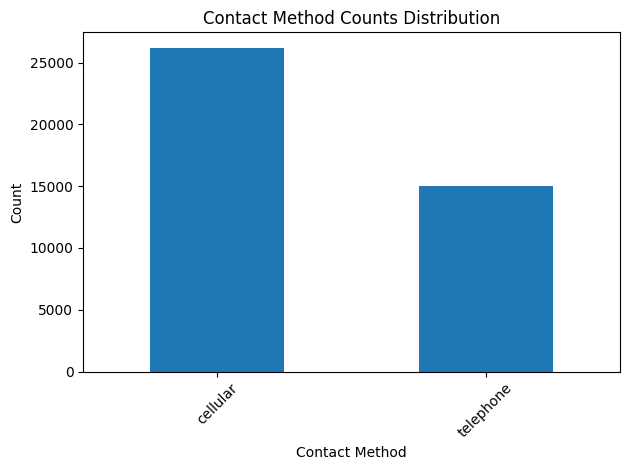

In [12]:
bank_df_2 = bank_df.copy()
bank_df_2.loc[bank_df_2["Contact Method"] == 'Cell', "Contact Method"] = 'cellular'
bank_df_2.loc[bank_df_2["Contact Method"] == 'Telephone', "Contact Method"] = 'telephone'

bank_df_2['Contact Method'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Contact Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Contact Method Counts Distribution')
plt.tight_layout()
plt.show()

## Campaign Calls Distribution

When all values, including negative ones, are including in the graph, the distribution is a Gaussian distribution with a sharp 'spike' in the centre. It is theoretically possible that the data recording system subtracted a flat value from all records, but that is hard to prove.

When the negative values are imputed by their absolute value, the distribution is a skewed 'right half' of a Gaussian distribution cut off at the 0 point.

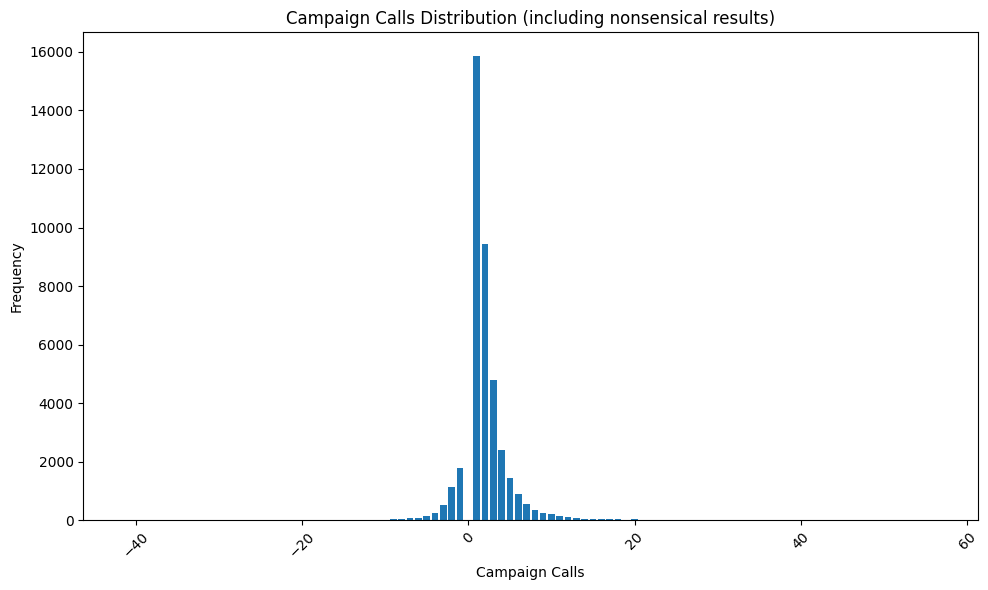

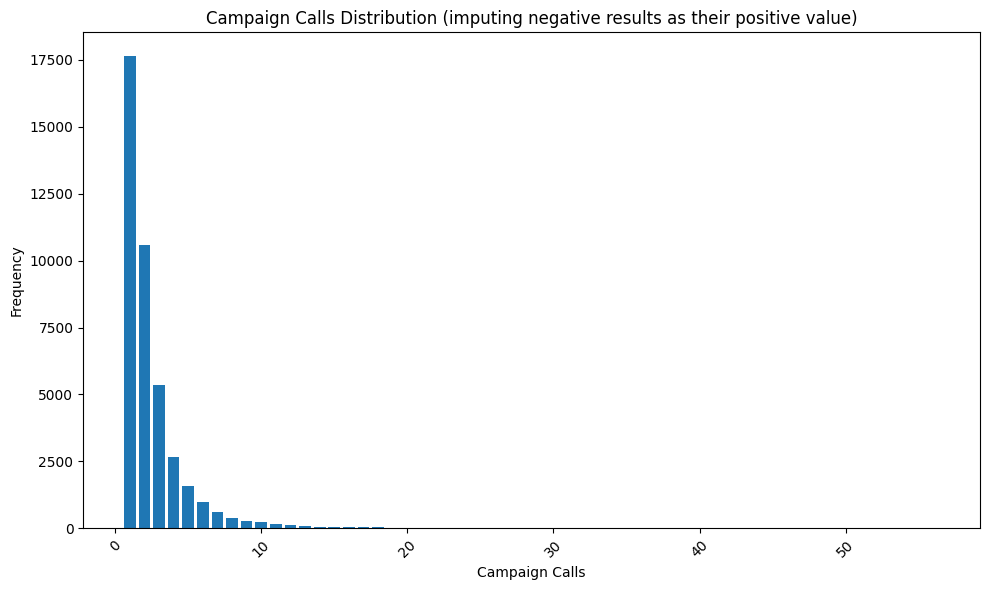

In [13]:
bank_df_2 = bank_df.copy()

# Count frequency of each age
calls_counts = bank_df_2["Campaign Calls"].value_counts().sort_index()

# Plot as bar chart
plt.figure(figsize=(10, 6))
plt.bar(calls_counts.index, calls_counts.values)
plt.xlabel('Campaign Calls')
plt.ylabel('Frequency')
plt.title('Campaign Calls Distribution (including nonsensical results)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

bank_df_2 = bank_df.copy()

# Count frequency of each age
bank_df_2["Campaign Calls"] = bank_df_2["Campaign Calls"].abs()
calls_counts = bank_df_2["Campaign Calls"].value_counts().sort_index()

# Plot as bar chart
plt.figure(figsize=(10, 6))
plt.bar(calls_counts.index, calls_counts.values)
plt.xlabel('Campaign Calls')
plt.ylabel('Frequency')
plt.title('Campaign Calls Distribution (imputing negative results as their positive value)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Previous Contact Days

The number of '999' records (saying that the customer has never been contacted before) is significant, making the distribution impossible to visualise.

Once the 999 records are removed, the distribution roughly looks Gaussian. In the end, an additional column will be added called "Contact Days Mask", set to 1 if the customer has never been contacted before, and 0 otherwise. Any values set to 999 will be set to 0, instead.

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: Previous Contact Days, dtype: float64


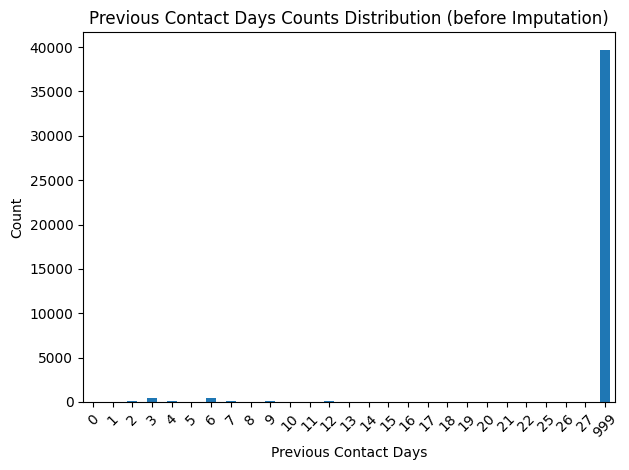

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: Previous Contact Days, dtype: float64


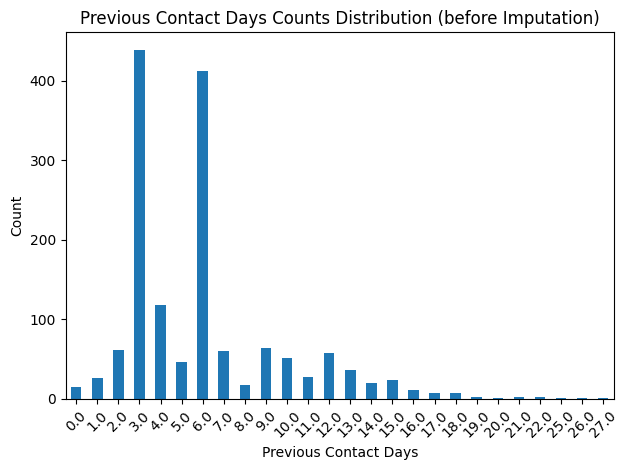

In [14]:
bank_df_2 = bank_df.copy()

print(bank_df_2["Previous Contact Days"].describe())

# Count frequency of each age

# Plot as bar chart
bank_df_2['Previous Contact Days'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xlabel('Previous Contact Days')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Previous Contact Days Counts Distribution (before Imputation)')
plt.tight_layout()
plt.show()

# Temporarily remove all 999s

bank_df_2 = bank_df.copy()
bank_df_2.loc[bank_df_2["Previous Contact Days"] == 999, "Previous Contact Days"] = None

print(bank_df_2["Previous Contact Days"].describe())

bank_df_2['Previous Contact Days'].value_counts(dropna=True).sort_index().plot(kind='bar')
plt.xlabel('Previous Contact Days')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Previous Contact Days Counts Distribution (before Imputation)')
plt.tight_layout()
plt.show()

## Subscription Status Counts:

There are significantly more no and yes records. Oversampling may need to be done to train the model.

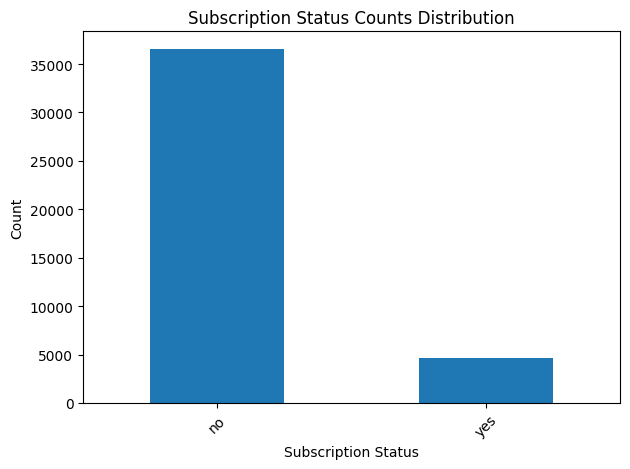

In [15]:
bank_df_2 = bank_df.copy()

bank_df_2['Subscription Status'].value_counts(dropna=True).sort_index().plot(kind='bar')
plt.xlabel('Subscription Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Subscription Status Counts Distribution')
plt.tight_layout()
plt.show()

Data somewhat resembles a normal distribution, after all 999s removed. May be better to perform some sort of data masking.

## Heat Maps

The best correlated column to Subscription Status is 'Previous Contact Days', along with Contact Method (cellular), the contactee being retired or a student. Credit Default = no is also correlated, but it is a poor feature and will be removed

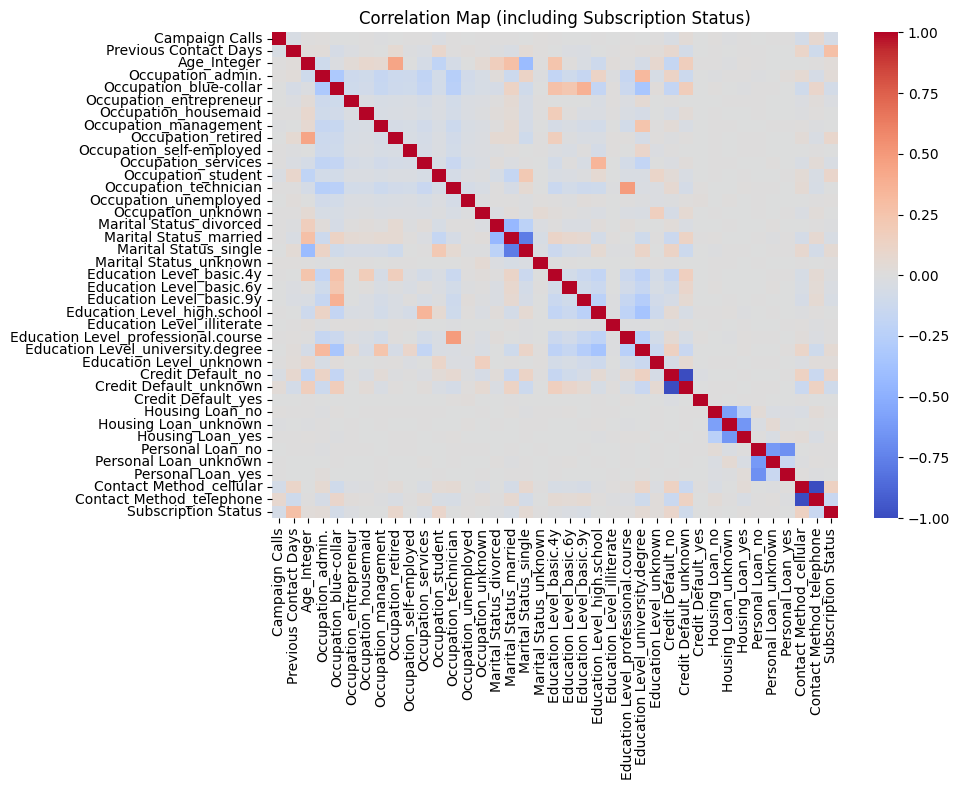

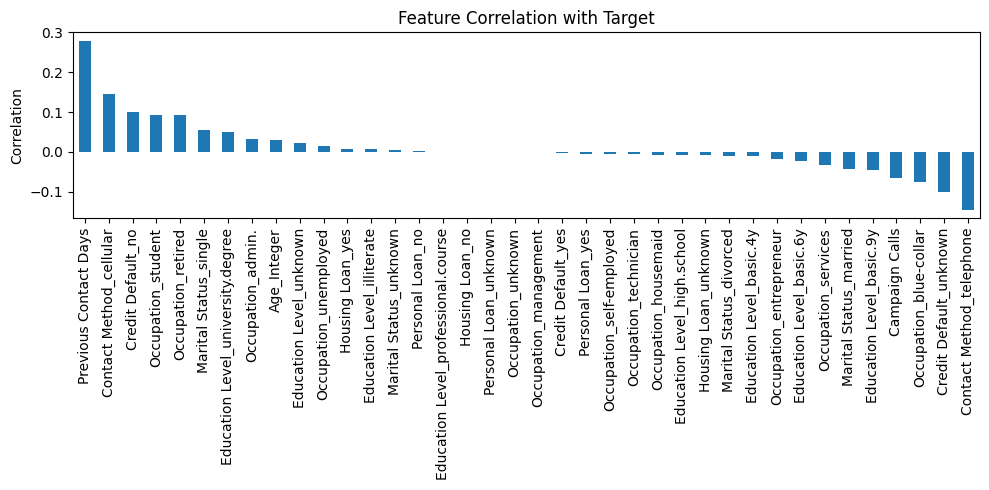

In [16]:
# Correlation Checks

corr_df = df_imputed.copy()
corr_df.loc[corr_df["Previous Contact Days"] == 999, "Previous Contact Days"] = -1

corr_df["Subscription Status"] = bank_df["Subscription Status"]
corr_df.loc[corr_df["Subscription Status"] == 'yes', 'Subscription Status'] = 1
corr_df.loc[corr_df["Subscription Status"] == 'no', 'Subscription Status'] = 0
corr_df["Subscription Status"] = corr_df["Subscription Status"].astype(int)

correlation_matrix = corr_df.corr(numeric_only=True)

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Map (including Subscription Status)")
plt.tight_layout()
plt.show()

cor_target = correlation_matrix['Subscription Status'].drop('Subscription Status').sort_values(ascending=False)
cor_target.plot(kind='bar', title='Feature Correlation with Target', figsize=(10, 5))
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()